In [1]:
!pip install blimpy
!pip install setigen

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 5.4MB 27.0MB/s 
     |████████████████████████████████| 6.4MB 4.0MB/s 


In [0]:
import math
%matplotlib inline
import pylab as plt
import numpy as np 
from blimpy import Waterfall
from astropy import units as u
import numpy as np
import setigen as stg
from copy import deepcopy

def SNR(arr):
  index = np.argmax(arr)
  average_noise = arr.mean(axis=0)
  return math.log(arr[index]/average_noise) 

def delay(fchan, data, DM):
  val = 1+data.shape[1]-fchan
  return int(DM*val**2)

def de_disperse(data,DM):
  clean = deepcopy(data)
  for i in range(clean.shape[1]):
    end = clean.shape[0]
    time = delay(i,clean, DM)
    if time!=0 and time<clean.shape[0]:
      zero_block = np.zeros((time))
      shift_block = clean[:end-time,i]
      clean[time:end,i]= shift_block
      clean[:time,i]= zero_block
    elif time!=0:
      clean[:,i]= np.zeros(clean[:,i].shape)
  return clean

def DM_can(data, data_base, sens, DM_base, candidates ):
  snrs = np.zeros((candidates,2))
  for i in range(candidates):
    DM = DM_base+sens*i
    data = de_disperse(data, DM=DM)
    time_series = data.sum(axis=1)
    snrs[i,1] = SNR(time_series)
    snrs[i,0] =DM
    if i%int(candidates/10)==0:
      print(snrs[i,1])
    data = data_base
  return snrs

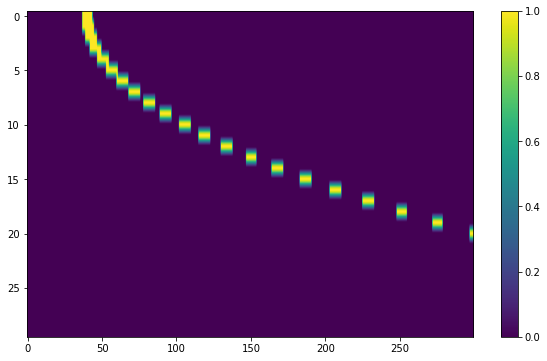

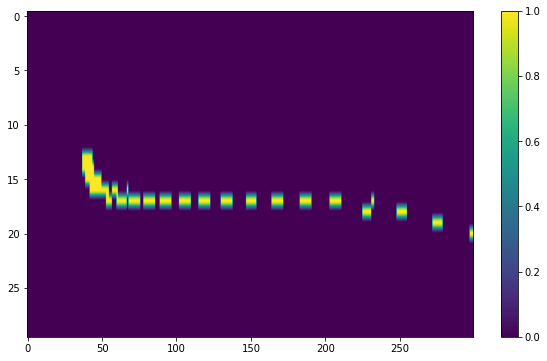

In [174]:


# Define time and frequency arrays, essentially labels for the 2D data array
fchans = 300
tchans = 30
df = 2.7939677238464355+10
dt = 18.25361108
fch1 = 6095.214842353016 * 10**6

# Generate the signal
frame = stg.Frame(fchans=fchans,
                  tchans=tchans,
                  df=df,
                  dt=dt,
                  fch1=fch1)

signal = frame.add_signal(stg.squared_path(f_start=frame.get_frequency(40),
                                           drift_rate=0.05*u.Hz/u.s),
                          stg.constant_t_profile(level=10),
                          stg.box_f_profile(width=100*u.Hz),
                          stg.constant_bp_profile(level=0.1))
data = frame.data
fig = plt.figure(figsize=(10, 6))
plt.imshow(data, aspect='auto')
plt.colorbar()
plt.show()

DM = 0.0002
clean = de_disperse(data, DM=DM)
fig = plt.figure(figsize=(10, 6))
plt.imshow(clean, aspect='auto')
plt.colorbar()
plt.show() 

In [177]:
frame = stg.Frame(fchans=fchans,
                  tchans=tchans,
                  df=df,
                  dt=dt,
                  fch1=fch1)

signal = frame.add_signal(stg.squared_path(f_start=frame.get_frequency(40),
                                           drift_rate=0.05*u.Hz/u.s),
                          stg.constant_t_profile(level=10),
                          stg.box_f_profile(width=100*u.Hz),
                          stg.constant_bp_profile(level=0.1))



data_base = frame.data
data = frame.data
sens = 0.0000001
DM_base = 0.00001
candidates = 5000

snrs = DM_can(data, data_base, sens, DM_base, candidates)



0.41173472112175985
1.104881901681705
1.2226649373380887
2.02117263355586
2.6497812929782345
2.302585092994046
1.9432110920861483
1.7980290822416505
1.791759469228055
2.1092137000135063


Text(0, 0.5, 'SNR of Dedispersion')

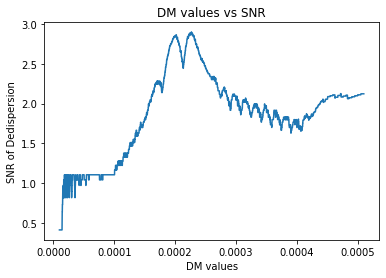

In [178]:
plt.plot(snrs[:,0], snrs[:,1])
plt.title('DM values vs SNR')
plt.xlabel("DM values")
plt.ylabel("SNR of Dedispersion")

In [180]:
print(snrs[np.argmax(snrs[:,1]),0])

0.0002264
